In [1]:
import numpy as np
from pathlib import Path
from math import ceil
import matplotlib.pyplot as plt

from lltypeiip.config import config

In [3]:
with open('/home/cal/analam/Documents/LL_typeIIP/sed_sample.txt', 'r') as file:
    oids = [line.rstrip() for line in file]

In [4]:
def summarize_npz(fp, label=None):
    d = np.load(fp, allow_pickle=True)

    chain = d["chain"]  # shape (nsteps, nwalkers, ndim)
    logp_chain = d["log_prob_chain"]  # (nsteps, nwalkers)
    af = d["acceptance_fraction"]  # (nwalkers,)

    nsteps, nwalkers, ndim = chain.shape

    tau = d["autocorr_time"]
    if tau is None or (isinstance(tau, np.ndarray) and tau.size == 0):
        tau = None
        tau_max = None
    else:
        tau = np.asarray(tau, float)
        tau_max = float(np.nanmax(tau))

    burnin = nsteps - (len(d["log_prob"]) // nwalkers)  # infer from saved flat samples
    post_steps = nsteps - burnin
    n_post = post_steps * nwalkers

    # quick stationarity check: compare medians between halves (post burn)
    post_chain = chain[burnin:, :, :]  # (post_steps, nwalkers, ndim)
    mid = post_chain.shape[0] // 2
    a = post_chain[:mid].reshape(-1, ndim)
    b = post_chain[mid:].reshape(-1, ndim)
    med_a = np.median(a, axis=0)
    med_b = np.median(b, axis=0)
    rel_shift = np.abs(med_b - med_a) / (np.abs(med_b) + 1e-12)

    logp = d["log_prob"]
    logp_med = float(np.median(logp))
    logp_max = float(np.max(logp))

    af_med = float(np.median(af))
    af_min = float(np.min(af))
    af_max = float(np.max(af))

    # ESS estimate (very rough)
    ess = None
    if tau_max is not None and np.isfinite(tau_max) and tau_max > 0:
        ess = n_post / (2.0 * tau_max)

    # Production recommendation based on tau_max
    prod_steps = None
    prod_burn = None
    if tau_max is not None and np.isfinite(tau_max) and tau_max > 0:
        prod_burn = int(ceil(4 * tau_max))
        prod_steps = int(ceil(50 * tau_max))  # conservative

    name = label or fp.stem
    print(f"\n=== {name} ===")
    print(f"nwalkers={nwalkers}, nsteps={nsteps}, burnin≈{burnin}, post={post_steps} steps => N_post={n_post}")
    print(f"logP: median={logp_med:.2f}, max={logp_max:.2f}, chi2_med≈{-2*logp_med:.2f}")
    print(f"acceptance: median={af_med:.3f}, min={af_min:.3f}, max={af_max:.3f}")

    if tau_max is None:
        print("autocorr_time: unavailable (run too short or failed).")
    else:
        print(f"autocorr_time: {tau}  | max(tau)={tau_max:.1f}  | steps/max(tau)={nsteps/tau_max:.1f}")
        print(f"rough ESS total ≈ {ess:.0f}")
        print(f"median shift (half1→half2) per param (relative): {rel_shift}")

        print(f"production suggestion: burnin≈{prod_burn}, nsteps≈{prod_steps} (for steps/max(tau)~50)")


In [ ]:

for oid in oids:
    outdir = Path(config.paths.mcmc_results_dir) / oid
    print("-----------")
    print(oid)
    print("-----------")
    for mode in ["data", "anchored", "mixture"]:
        fp = outdir / f"mcmc_{oid}_{mode}.npz"
        if fp.exists():
            summarize_npz(fp, mode)
    print(" ")

-----------
ZTF18abjndhh
-----------

=== data ===
nwalkers=24, nsteps=2000, burnin≈500, post=1500 steps => N_post=36000
logP: median=-2.67, max=-0.07, chi2_med≈5.34
acceptance: median=0.306, min=0.199, max=0.361
autocorr_time: [152.1255187  120.20863594 149.49120655 156.47772409]  | max(tau)=156.5  | steps/max(tau)=12.8
rough ESS total ≈ 115
median shift (half1→half2) per param (relative): [0.01305542 0.11139674 0.16129606 0.00034624]
production suggestion: burnin≈626, nsteps≈7824 (for steps/max(tau)~50)

=== anchored ===
nwalkers=24, nsteps=2000, burnin≈500, post=1500 steps => N_post=36000
logP: median=-2.43, max=-0.53, chi2_med≈4.85
acceptance: median=0.463, min=0.419, max=0.488
autocorr_time: [115.06773408  60.95386073 106.5237768  118.26309965]  | max(tau)=118.3  | steps/max(tau)=16.9
rough ESS total ≈ 152
median shift (half1→half2) per param (relative): [0.02241886 0.01127051 0.04370801 0.00149822]
production suggestion: burnin≈474, nsteps≈5914 (for steps/max(tau)~50)

=== mixtur

In [14]:
PARAMS = ["tstar", "tdust", "log10_tau", "log10_a"]
RESULTS_ROOT = Path(config.paths.mcmc_results_dir)

def load_run(oid, mode):
    outdir = Path(config.paths.mcmc_results_dir) / oid
    fp = outdir / f"mcmc_{oid}_{mode}.npz"
    z = np.load(fp, allow_pickle=True)
    return fp, z


oid = "ZTF18abjndhh"
mode = "data"
path, z = load_run(oid, mode)

print("Loaded:", path)
print("Keys:", list(z.keys()))
print("chain shape:", z["chain"].shape)  # (nsteps, nwalkers, ndim)
print("log_prob_chain shape:", z["log_prob_chain"].shape)
print("acceptance_fraction:", np.mean(z["acceptance_fraction"]))

Loaded: /home/cal/analam/Documents/LL_typeIIP/mcmc_results/ZTF18abjndhh/mcmc_ZTF18abjndhh_data.npz
Keys: ['samples', 'log_prob', 'chain', 'log_prob_chain', 'acceptance_fraction', 'autocorr_time', 'tstar', 'tdust', 'tau', 'a', 'grid_best', 'prior_config', 'seed', 'mode']
chain shape: (2000, 24, 4)
log_prob_chain shape: (2000, 24)
acceptance_fraction: 0.29470833333333335


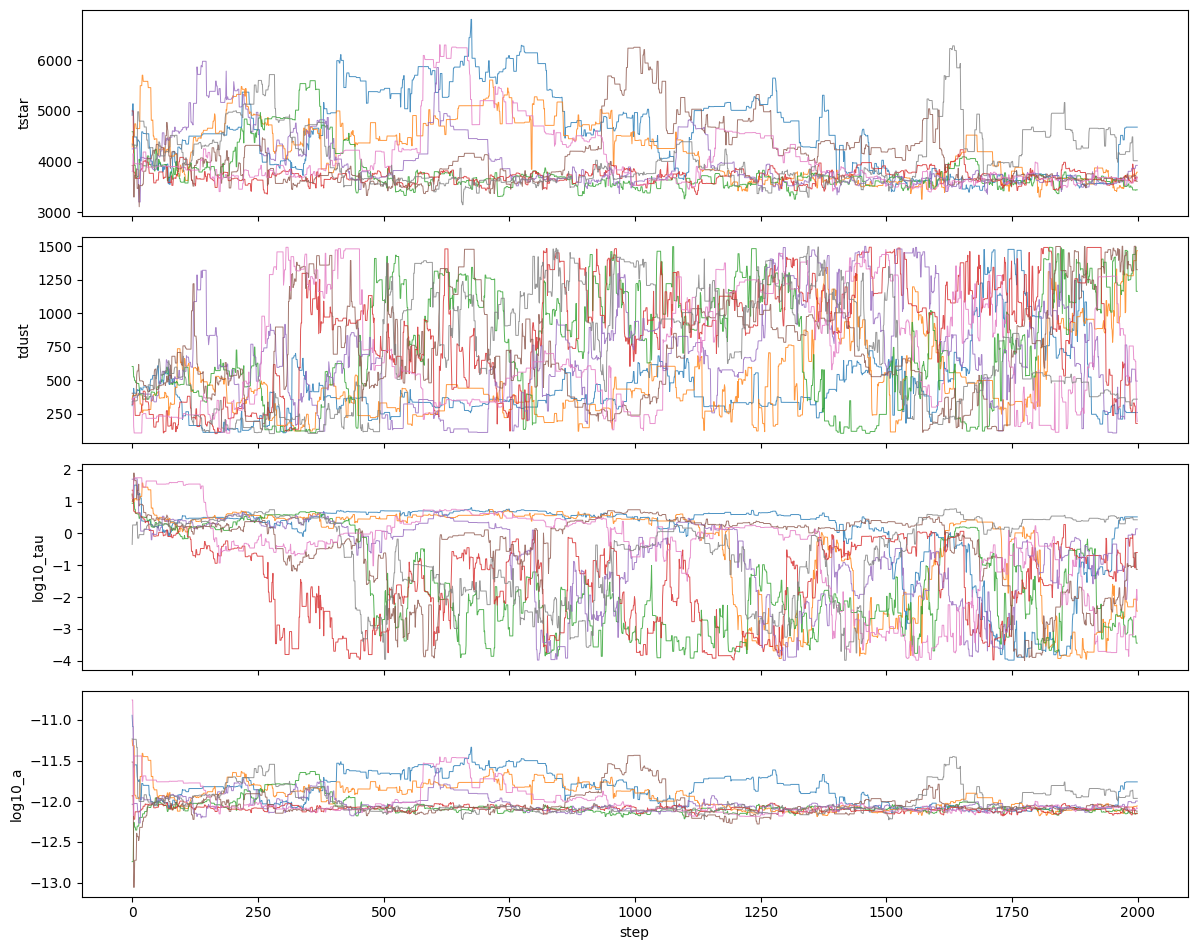

In [18]:
def plot_traces(chain, burn=0, params=PARAMS, nwalkers_to_show=8):
    nsteps, nwalkers, ndim = chain.shape
    w = min(nwalkers, nwalkers_to_show)
    fig, axes = plt.subplots(ndim, 1, figsize=(12, 2.4*ndim), sharex=True)
    for j in range(ndim):
        ax = axes[j]
        for i in range(w):
            ax.plot(chain[burn:, i, j], lw=0.7, alpha=0.8)
        ax.set_ylabel(params[j])
    axes[-1].set_xlabel("step")
    plt.tight_layout()

chain = z["chain"]
burn = 0  # whatever you used
plot_traces(chain, burn=burn)

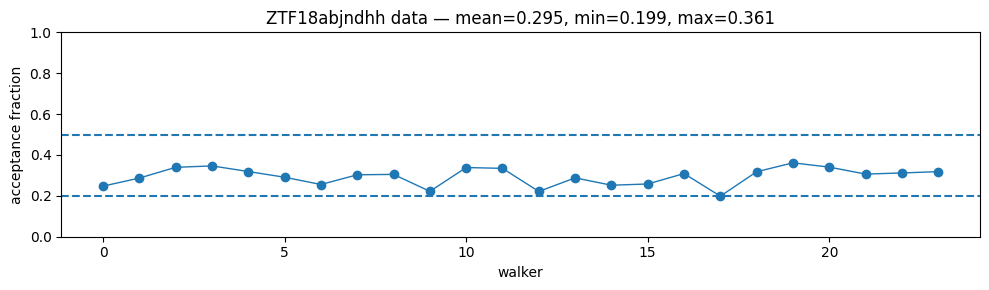

In [22]:
af = z["acceptance_fraction"]
plt.figure(figsize=(10,3))
plt.plot(af, marker="o", lw=1)
plt.axhline(0.2, ls="--")
plt.axhline(0.5, ls="--")
plt.ylim(0, 1)
plt.xlabel("walker")
plt.ylabel("acceptance fraction")
plt.title(f"{oid} {mode} — mean={af.mean():.3f}, min={af.min():.3f}, max={af.max():.3f}")
plt.tight_layout()

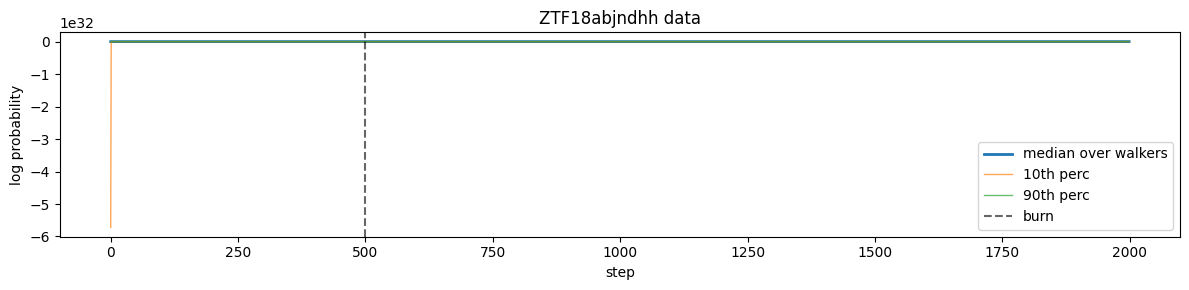

In [25]:
burn = 500
logp = z["log_prob_chain"]  # (nsteps, nwalkers)
plt.figure(figsize=(12,3))
plt.plot(np.nanmedian(logp, axis=1), lw=2, label="median over walkers")
plt.plot(np.nanpercentile(logp, 10, axis=1), lw=1, alpha=0.7, label="10th perc")
plt.plot(np.nanpercentile(logp, 90, axis=1), lw=1, alpha=0.7, label="90th perc")
plt.axvline(burn, color="k", ls="--", alpha=0.6, label="burn")
plt.xlabel("step")
plt.ylabel("log probability")
plt.title(f"{oid} {mode}")
plt.legend()
plt.tight_layout()

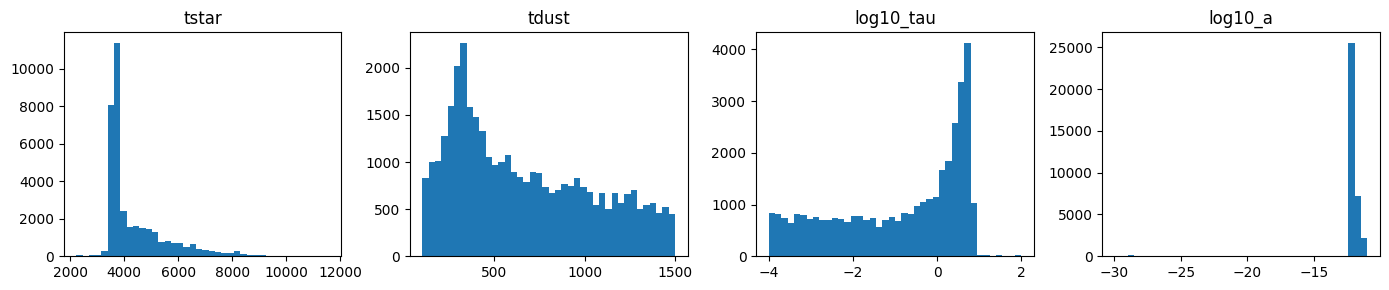

In [26]:
def get_flat_samples(chain, burn=0, thin=1):
    # chain: (nsteps, nwalkers, ndim)
    x = chain[burn::thin, :, :].reshape(-1, chain.shape[-1])
    return x

samples = get_flat_samples(chain, burn=burn, thin=1)

# 1D histograms
fig, axes = plt.subplots(1, 4, figsize=(14,3))
for j, ax in enumerate(axes):
    ax.hist(samples[:, j], bins=40)
    ax.set_title(PARAMS[j])
plt.tight_layout()

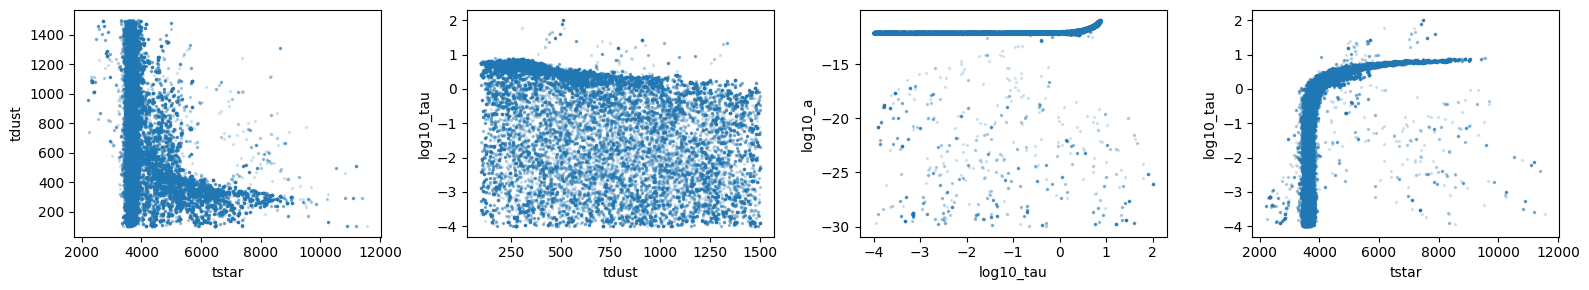

In [27]:
pairs = [(0,1), (1,2), (2,3), (0,2)]
fig, axes = plt.subplots(1, len(pairs), figsize=(4*len(pairs), 3))
for ax, (i,j) in zip(axes, pairs):
    ax.scatter(samples[:, i], samples[:, j], s=2, alpha=0.15)
    ax.set_xlabel(PARAMS[i])
    ax.set_ylabel(PARAMS[j])
plt.tight_layout()

In [28]:
def summarize_samples(z, burn, thin=1):
    chain = z["chain"]
    s = get_flat_samples(chain, burn=burn, thin=thin)
    q16, q50, q84 = np.percentile(s, [16, 50, 84], axis=0)
    return q16, q50, q84, s

modes = ["data", "anchored", "mixture"]
burn = 500

summaries = {}
for m in modes:
    path, z_m = load_run(oid, m)
    q16, q50, q84, s = summarize_samples(z_m, burn=burn)
    summaries[m] = dict(q16=q16, q50=q50, q84=q84, af=np.mean(z_m["acceptance_fraction"]))
    print(m, "mean af:", summaries[m]["af"])

data mean af: 0.29470833333333335
anchored mean af: 0.46064583333333325
mixture mean af: 0.312375


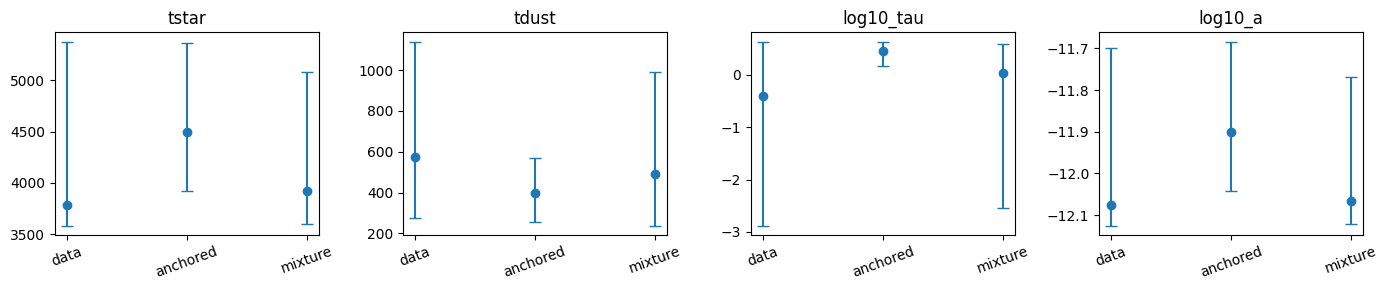

In [29]:
fig, axes = plt.subplots(1, 4, figsize=(14,3), sharey=False)
x = np.arange(len(modes))
for j, ax in enumerate(axes):
    med = [summaries[m]["q50"][j] for m in modes]
    lo  = [summaries[m]["q50"][j] - summaries[m]["q16"][j] for m in modes]
    hi  = [summaries[m]["q84"][j] - summaries[m]["q50"][j] for m in modes]
    ax.errorbar(x, med, yerr=[lo,hi], fmt="o", capsize=4)
    ax.set_xticks(x)
    ax.set_xticklabels(modes, rotation=20)
    ax.set_title(PARAMS[j])
plt.tight_layout()


In [ ]:
def split_rhat(chain, burn=0):
    """
    chain: (nsteps, nwalkers, ndim)
    Uses split-Rhat by splitting each walker chain into two halves,
    treating each half as a chain.
    """
    x = chain[burn:, :, :]  # (T, W, D)
    T, W, D = x.shape
    if T < 20:
        return np.full(D, np.nan)

    half = T // 2
    a = x[:half, :, :]
    b = x[half:2*half, :, :]

    # reshape to (nchains, n, ndim)
    chains = np.concatenate([a.transpose(1,0,2), b.transpose(1,0,2)], axis=0)  # (2W, half, D)
    M, N, D = chains.shape

    chain_means = chains.mean(axis=1)          # (M, D)
    chain_vars  = chains.var(axis=1, ddof=1)   # (M, D)

    W_var = chain_vars.mean(axis=0)            # within-chain var (D,)
    B_var = N * chain_means.var(axis=0, ddof=1)  # between-chain var (D,)

    var_hat = (N-1)/N * W_var + B_var/N
    Rhat = np.sqrt(var_hat / W_var)
    return Rhat

rhat = split_rhat(z["chain"], burn=burn)
dict(zip(PARAMS, rhat))

{'tstar': np.float64(1.7996508140778158),
 'tdust': np.float64(1.292414706799784),
 'log10_tau': np.float64(1.439031835222892),
 'log10_a': np.float64(1.9293753535757159)}

In [31]:
def ess_from_tau(chain, tau, burn=0):
    T, W, D = chain.shape
    T_eff = T - burn
    ess = W * T_eff / tau
    return ess

if "autocorr_time" in z and z["autocorr_time"] is not None:
    tau = z["autocorr_time"]
    print("tau:", tau)
    print("ESS:", ess_from_tau(z["chain"], tau, burn=burn))


tau: [152.1255187  120.20863594 149.49120655 156.47772409]
ESS: [236.64668694 299.47931543 240.8168402  230.06469585]


In [42]:
import pandas as pd

print(oids)
records = []
burn_default = 500  # change to match run
outdir = Path(config.paths.mcmc_results_dir)

for oid in oids:
    for mode in ["data", "anchored", "mixture"]:
        path = outdir / oid / f"mcmc_{oid}_{mode}.npz"
        z = np.load(path, allow_pickle=True)
        chain = z["chain"]
        af = z["acceptance_fraction"]
        rhat = split_rhat(chain, burn=burn_default)
        records.append(dict(
            oid=oid,
            mode=mode,
            path=str(path),
            nsteps=chain.shape[0],
            nwalkers=chain.shape[1],
            af_mean=float(np.mean(af)),
            af_min=float(np.min(af)),
            af_max=float(np.max(af)),
            rhat_max=float(np.nanmax(rhat)),
            rhat_tstar=float(rhat[0]),
            rhat_tdust=float(rhat[1]),
            rhat_log10_tau=float(rhat[2]),
            rhat_log10_a=float(rhat[3]),
        ))

df = pd.DataFrame.from_records(records)
df.to_csv("summary.csv")
df


['ZTF18abjndhh', 'ZTF19aadnxnl', 'ZTF19aclobbu', 'ZTF21aagtqna', 'ZTF21abnlhxs', 'ZTF22aativsd', 'ZTF23aanymcl', 'ZTF23aaxadel']


,oid,mode,path,nsteps,nwalkers,af_mean,af_min,af_max,rhat_max,rhat_tstar,rhat_tdust,rhat_log10_tau,rhat_log10_a
0,ZTF18abjndhh,data,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.294708,0.1985,0.3615,1.929375,1.799651,1.292415,1.439032,1.929375
1,ZTF18abjndhh,anchored,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.460646,0.4190,0.4880,1.233662,1.166019,1.064135,1.233662,1.168088
2,ZTF18abjndhh,mixture,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.312375,0.2300,0.3710,2.079154,1.395437,1.214118,1.360093,2.079154
3,ZTF19aadnxnl,data,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.551625,0.5180,0.5740,1.062897,1.062793,1.048940,1.060958,1.062897
4,ZTF19aadnxnl,anchored,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.569833,0.5435,0.5955,1.043825,1.037204,1.043825,1.039952,1.037343
5,ZTF19aadnxnl,mixture,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.562688,0.5300,0.5840,1.043383,1.042303,1.041474,1.043383,1.043290
6,ZTF19aclobbu,data,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.331687,0.1930,0.4010,1.909507,1.431641,1.240624,1.909507,1.616011
7,ZTF19aclobbu,anchored,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.541875,0.5170,0.5730,1.059617,1.038425,1.050254,1.039947,1.059617
8,ZTF19aclobbu,mixture,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.367500,0.2415,0.4250,1.956105,1.352506,1.196455,1.770291,1.956105
9,ZTF21aagtqna,data,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...,2000,24,0.430208,0.3555,0.4685,1.149141,1.072377,1.149141,1.099941,1.067546


In [40]:
# simplest: lowest rhat_max with reasonable acceptance
df["score"] = df["rhat_max"] + 0.5*np.clip(np.abs(df["af_mean"]-0.3), 0, 1)

best = df.sort_values(["oid","score"]).groupby("oid").first().reset_index()
best[["oid","mode","af_mean","rhat_max","path"]].head(10)

,oid,mode,af_mean,rhat_max,path
0,ZTF18abjndhh,anchored,0.460646,1.233662,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...
1,ZTF19aadnxnl,mixture,0.562688,1.043383,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...
2,ZTF19aclobbu,anchored,0.541875,1.059617,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...
3,ZTF21aagtqna,data,0.430208,1.149141,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...
4,ZTF21abnlhxs,anchored,0.411458,20.703264,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...
5,ZTF22aativsd,data,0.507854,2.606585,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...
6,ZTF23aanymcl,anchored,0.487479,1.177828,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...
7,ZTF23aaxadel,anchored,0.506458,1.105665,/home/cal/analam/Documents/LL_typeIIP/mcmc_res...


In [44]:
df[["af_mean", "af_min", "af_max"]].describe()

,af_mean,af_min,af_max
count,24.000000,24.000000,24.000000
mean,0.447983,0.300063,0.493750
std,0.078558,0.167095,0.067385
min,0.294708,0.029000,0.361500
25%,0.409583,0.197125,0.465250
50%,0.458031,0.295500,0.497750
75%,0.506807,0.430750,0.539125
max,0.569833,0.543500,0.595500


In [46]:
df[["rhat_max"]].describe()

,rhat_max
count,24.000000
mean,4.166580
std,6.720290
min,1.043383
25%,1.170657
50%,1.782126
75%,2.292176
max,21.911021


In [47]:
df.groupby("mode")[["af_mean", "rhat_max",]].median()


,af_mean,rhat_max
mode,,
anchored,0.496969,1.205745
data,0.424531,1.782126
mixture,0.430594,1.965900
